In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
#import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from vips import vipp

## Plot PCA

In [5]:
counts = pd.read_csv("../data/BAL/train_fpkm_minfilter0_log2.csv",sep='\t',index_col=0)

meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

In [6]:
## Filter 

In [7]:
min_uniques = 4e6
min_gene_count = 10 ## All genes from all samples must have 10 counts
## AM
def filter_norm(df, meta, celltype, min_gene_count=0, min_uniques=0):
    meta['Norm_Factor'] = meta['Uniquely mapped reads number'].map(lambda x: float(x) / np.median(meta['Uniquely mapped reads number']))
    bal_dict = dict(zip(meta.index,meta['Norm_Factor']))
    samples_min_unique = meta[meta['Uniquely mapped reads number'] > min_uniques].index
    df = df.ix[samples_min_unique].T
    for i in df.columns:
        norm_fac = meta.loc[i,'Norm_Factor']
        df[i] = df[i].map(lambda x: float(x)/norm_fac)
    df = df.T
    df = df.loc[:, df.min(axis=0) > min_gene_count]
    df = df.apply(lambda x: np.log2(x + 1))
    dfm = meta.ix[df.index]
    return df, dfm

In [9]:
def get_non_outlier_indices(df, n_stages=1, zcut=2):
    outlier_inds = []
    for i in range(n_stages):
        pca = PCA(n_components=4)
        pca_fit = pca.fit_transform(df)
        pc1, pc2, pc3 = pca_fit.T[0], pca_fit.T[1], pca_fit.T[2]
        z1, z2, z3 = zscore(pc1), zscore(pc2), zscore(pc3)
        #print pc1, z1
        n = len(z1)
        outlier_inds += [i for i in range(n) if abs(z1[i]) > zcut]
        outlier_inds += [i for i in range(n) if abs(z2[i]) > zcut and i not in outlier_inds]
        outlier_inds += [i for i in range(n) if abs(z3[i]) > zcut and i not in outlier_inds]
        for i in range(n):
            if pc1[i] > 20:
                print i, pc1[i], z1[i]
        non_outlier_inds = [i for i in range(n) if i not in outlier_inds]
        print outlier_inds
        df = df.ix[non_outlier_inds,]
    return non_outlier_inds

In [10]:
def plot_pca(counts, meta, celltype, PCs=[1,2], color_label='Pneum', label_pseudomonas=False, 
             label_flu=False, size_col=None, size_scale=100, size_label=True, 
             limits=None, legend_loc='top_right', remove_outliers=False, z_score=True,
             min_gene_count=0, min_uniques=0):
    
    plt.figure(figsize=(8,6))
    dfm = meta[meta['CellType']==celltype]
    df = counts.ix[dfm.index]
    print df.shape
    #df, dfm = filter_norm(df, dfm, celltype, min_gene_count, min_uniques)
    print df.shape
    colors = {0: 'b', 1: 'orange'} 
    sizes = [size_scale for x in dfm.index]
    
    ### SIZE_COL designates the size of the points
    if size_col: 
        ### IMPUTE NANs by using mean
        dfm[size_col] = dfm[size_col].map(lambda x: np.mean(dfm[size_col]) if np.isnan(x) else x)
        ### Z-SCORE Results
        scores = zscore(dfm[size_col])
        scale = size_scale
        rng = 0.5 ## 50% variation in size
        sizes = [scale + scale*rng*i for i in scores]
    
    ### Run PCA, get labels
    
    ###
    PCi = [x-1 for x in PCs] # PC indices based on input (input PC1 -> PCi=0)
    
    #### Remove outliers
    if remove_outliers != 0:
        print "removing outliers"
        non_outlier_indices = get_non_outlier_indices(df, n_stages=remove_outliers)
        df = df.ix[non_outlier_indices,]
        dfm = dfm.ix[non_outlier_indices,]
        
    if z_score:
        #df = df.apply(zscore, axis=1)
        df = df.apply(zscore, axis=0)

    #### Re-do PCA with outliers removed    

    pca = PCA(n_components=4)
    pca_fit = pca.fit_transform(df)
    pcs = zip(pca_fit.T[PCi[0]], pca_fit.T[PCi[1]])
    
    BALs = df.index
    sample_labels = dfm['Pneum'].values
    
    n_samples = len(pcs)

    ### Color by pneumonia bacteria +/-
    name_dict = {False: 'Negative', True: 'Positive'}#, 'unknown': 'Unknown'}
    labels = name_dict.keys()
    for label in set(labels):
        s = [sizes[i] for i in range(n_samples) if sample_labels[i]==label]
        pc_label = [pcs[i] for i in range(len(pcs)) if sample_labels[i]==label]
        plt.scatter(*zip(*pc_label), color=colors[label], label=name_dict[label], s=s)
        
    ### Label pseudomonas
    pseud_BALs = ['BAL' + str(x) for x in [46, 49, 50, 75, 83]]
    pc_label = [pcs[i] for i in range(n_samples) if any(pb in BALs[i] for pb in pseud_BALs)]
    if label_pseudomonas and len(pc_label) > 0:
        print pc_label
        plt.scatter(*zip(*pc_label), s=sizes, marker='o', color='r', label='Pseudomonas (Pos.)')
    
    ### Label flu
    flu_BALs = ['BAL' + str(x) for x in [52, 53, 55]]
    pc_label = [pcs[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    s = [sizes[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    if label_flu and len(pc_label) > 0: 
        plt.scatter(*zip(*pc_label), s=s, marker='o', color='m', label='Flu (+Pos.)')
        
    ### Plot PCA
    plt.title('Human ' + celltype + ' Cells, ' + str(df.shape[1]) + ' genes', fontsize=14)
    plt.xlabel('PC {0} \n {1: .1f}% var exp'.format(PCs[0], pca.explained_variance_ratio_[PCi[0]]*100), fontsize=14)
    plt.ylabel('PC {0} \n {1: .1f}% var exp'.format(PCs[1], pca.explained_variance_ratio_[PCi[1]]*100), fontsize=14)
    
    ### Set limits if given
    if limits:
        plt.xlim(limits['x'][0],limits['x'][1])
        plt.ylim(limits['y'][0],limits['y'][1])
        if size_label: 
            plt.text(limits['x'][0]+1, limits['y'][1] - 4, 'Size: ' + size_col, fontsize=12)
    elif size_col and size_label:
        plt.text(0,0, 'Size: ' + size_col, fontsize=8)
    
    ### Fix legend
    loc_dict = {'side': [1.4, 0.5], 'top_right': [1, 1], 'bottom_right': [1, 0.3], 
                'top_left': [0.1, 1], 'bottom_left': [0.1, 0.3]}
    loc = loc_dict[legend_loc]
    #legend = plt.legend(frameon=True)#, bbox_to_anchor=(loc), title = 'Bacterial culture', fontsize=12)
    #frame = legend.get_frame()
    #frame.set_facecolor('white')
    #plt.legend()
    if legend_loc:
        legend = plt.legend(frameon=True, bbox_to_anchor=(loc_dict[legend_loc]))
    else:
        legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.show()

### pseudomonas labels for plotting

In [11]:
pseudo_BALs = [46, 49, 50, 75, 83]

In [12]:
meta['pseudo'] = meta['BAL'].map(lambda x: any(str(p) in x for p in pseudo_BALs))

In [16]:
import seaborn as sns
def plot_cluster(counts, meta, celltype, rem_loners=False, vipcut=1.5, label='Pneum'):
    
    dfm = meta[meta['CellType']==celltype]
    df = counts.ix[dfm.index]
    print df.shape
    #print df.shape, "original"
    #df,dfm = filter_norm(df, dfm, celltype, min_gene_count, min_uniques)
    #print df.shape, "after gene count, uniques filter"

    plsv = PLSRegression(5, scale=False)
    X, y = np.array(df), np.array(dfm['Pneum'])
    plsv.fit(X, y)
    vips = vipp(X, y, plsv.x_scores_, plsv.x_weights_)
    vips = [float(v) for v in vips]
    DE_inds = [i for i in range(len(vips)) if vips[i] > vipcut]
    #DE_inds = [i + 2 for i in DE_inds]
    df=df[DE_inds]
    print df.shape
    
    df = df.apply(zscore, axis=1)
    df = df.apply(zscore, axis=0)

    dfplot = df.T
    dfplot = dfplot.rename(columns={c: dfm.loc[c,label] for c in dfplot.columns})

    #dfplot.columns
    plot_pca(df, dfm, celltype=celltype, PCs=[1,2], label_pseudomonas=True, 
         label_flu=True,
         size_col=None, size_label=False, size_scale=150,
         limits=None, legend_loc='side', remove_outliers=0, 
         z_score=False)
    fig = sns.clustermap(dfplot, col_cluster=True)
    sns.set()
    sns.palplot(sns.diverging_palette(240, 10, n=9))

    #pseud_BALs = ['BAL' + str(x) for x in [46, 49, 50, 75, 83]]
#meta['Pseudomonas'] = meta['BAL'].map(lambda x: True if x in pseud_BALs else False )
    

(46, 11957)
(46, 306)
(46, 306)
(46, 306)
[(-11.885832673769166, 0.29834432236771463), (-9.5811118032619724, 0.97449257339877104), (13.694451606381186, 2.5462962808070708), (-4.3768270540623968, -2.6268764484279754)]


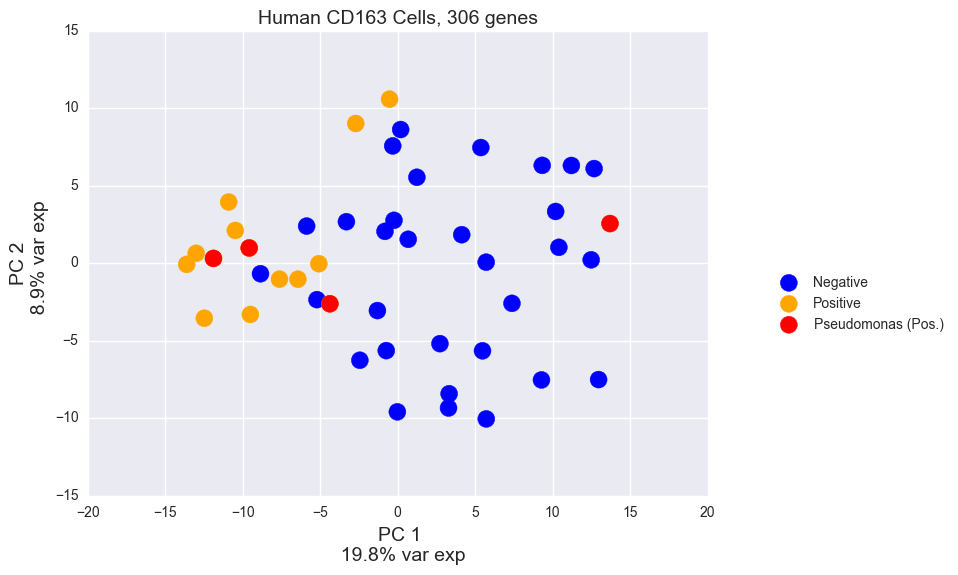

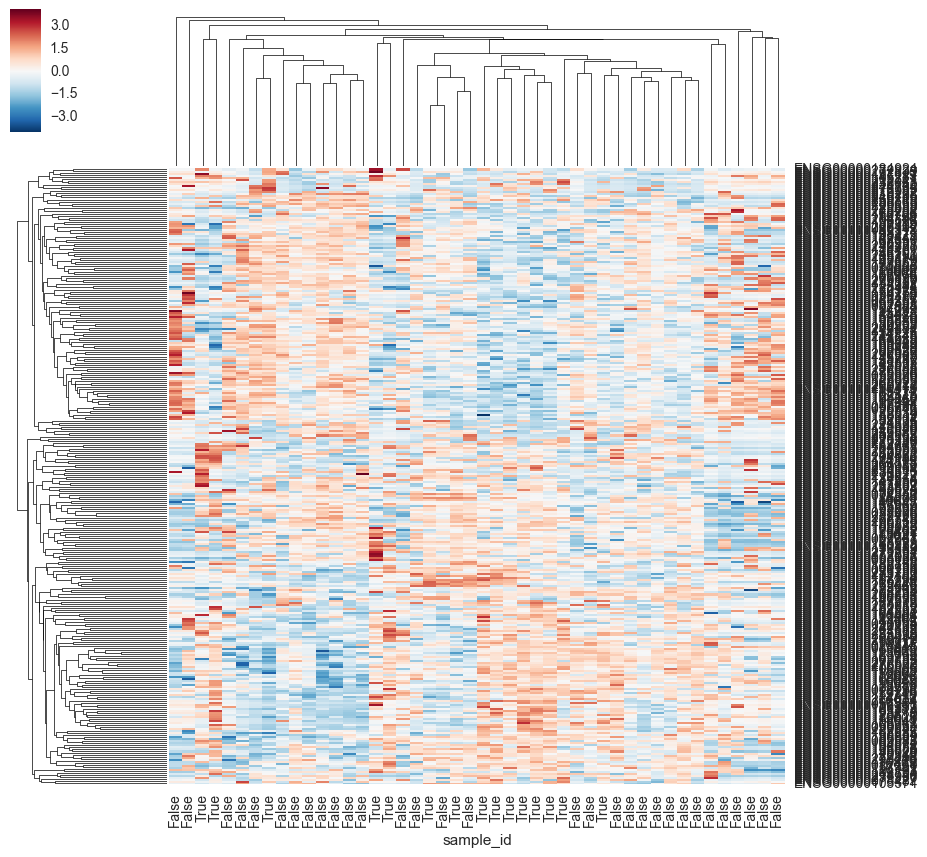

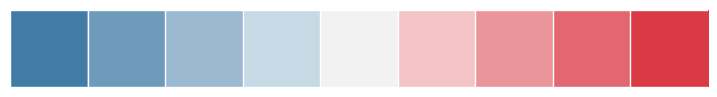

In [17]:
plot_cluster(counts, meta, celltype='CD163', vipcut=2.5, label='Pneum')

(49, 11957)
(49, 230)
(49, 230)
(49, 230)
[(-1.050260277741365, 1.3978294449779063), (-7.419316710687772, -4.0685864561772105), (-3.9149211124508674, -3.2659187503379705), (-4.3054598009982712, 2.4916347543577437)]


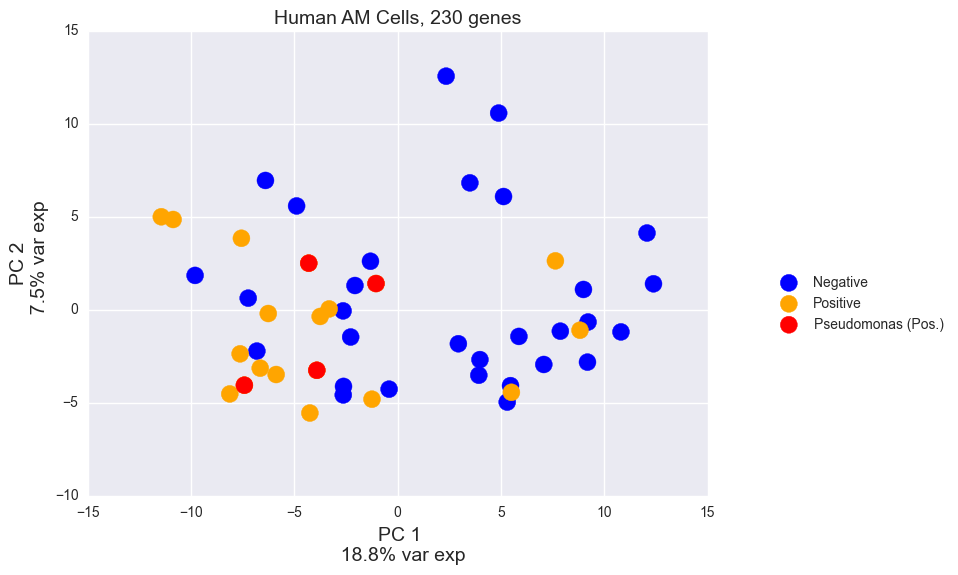

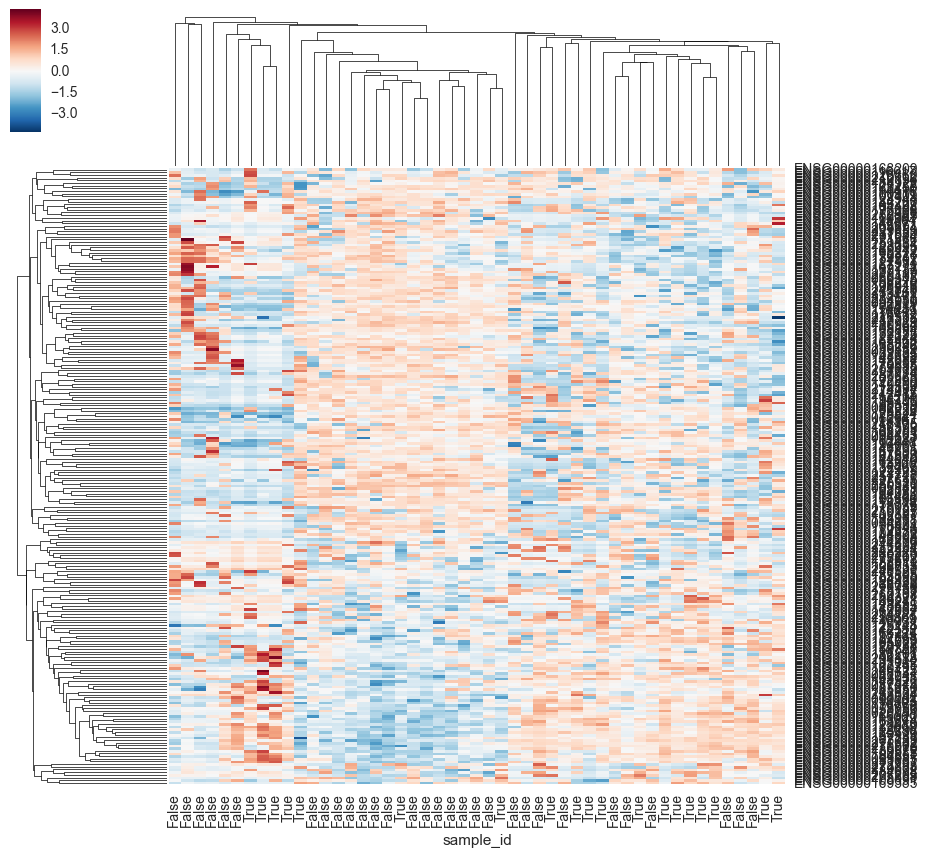

In [26]:
plot_cluster(counts, meta, celltype='AM', vipcut=2.5, label='Pneum')

In [12]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip